# Libs

In [12]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from sklearn.cluster import KMeans

#import matplotlib.dates as md

#from mpl_toolkits.axes_grid1 import host_subplot


#%matplotlib inline

# Import pre-processed data

In [2]:
df = pd.read_csv('data pre-processed.csv')
print(df['price_usd'].describe())
df.head()

count    3048.000000
mean      111.144055
std        55.055161
min         0.120000
25%        67.000000
50%       100.000000
75%       141.000000
max       536.000000
Name: price_usd, dtype: float64


,date_time,price_usd,srch_booking_window,srch_saturday_night_bool
0,2012-11-01 02:48:30,84.0,19,0
1,2012-11-01 03:06:43,78.0,16,1
2,2012-11-01 09:04:18,114.0,56,1
3,2012-11-01 09:11:03,76.0,56,1
4,2012-11-01 10:15:25,128.0,0,1


# Viz Data without Libs

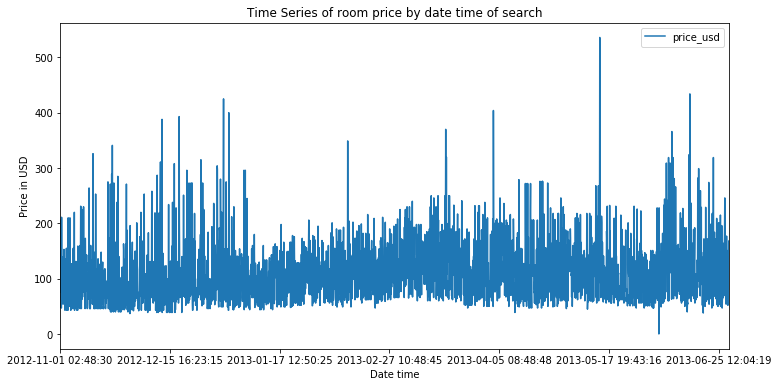

In [5]:
# plot the data
df.plot(x='date_time', y='price_usd', figsize=(12,6))
plt.xlabel('Date time')
plt.ylabel('Price in USD')
plt.title('Time Series of room price by date time of search');

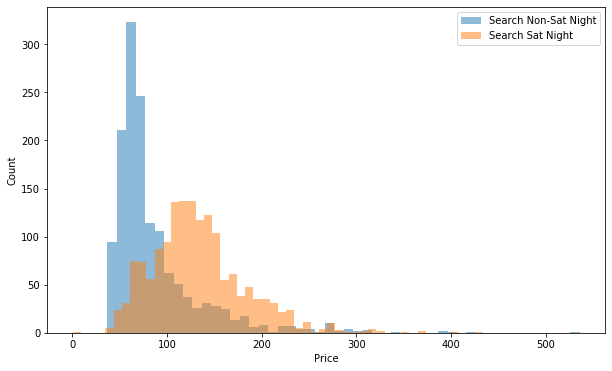

In [6]:
a = df.loc[df['srch_saturday_night_bool'] == 0, 'price_usd']
b = df.loc[df['srch_saturday_night_bool'] == 1, 'price_usd']

plt.figure(figsize=(10, 6))
plt.hist(a, bins = 50, alpha=0.5, label='Search Non-Sat Night')
plt.hist(b, bins = 50, alpha=0.5, label='Search Sat Night')
plt.legend(loc='upper right')
plt.xlabel('Price')
plt.ylabel('Count')
plt.show();

In [7]:
print(df['srch_saturday_night_bool'].value_counts(),"\n")
df.head()

1    1599
0    1449
Name: srch_saturday_night_bool, dtype: int64 



,date_time,price_usd,srch_booking_window,srch_saturday_night_bool
0,2012-11-01 02:48:30,84.0,19,0
1,2012-11-01 03:06:43,78.0,16,1
2,2012-11-01 09:04:18,114.0,56,1
3,2012-11-01 09:11:03,76.0,56,1
4,2012-11-01 10:15:25,128.0,0,1


# k-means
k-means is a widely used clustering algorithm. It creates 'k' similar clusters of data points. Data instances that fall outside of these groups could potentially be marked as anomalies.

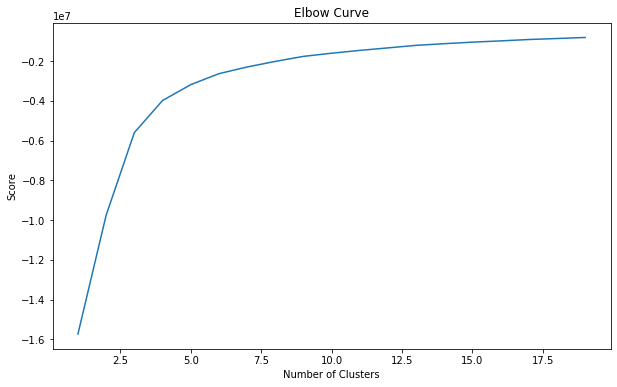

In [10]:
data = df[['price_usd', 'srch_booking_window', 'srch_saturday_night_bool']]
n_cluster = range(1, 20)
kmeans = [KMeans(n_clusters=i).fit(data) for i in n_cluster]
scores = [kmeans[i].score(data) for i in range(len(kmeans))]

# we can also use kmeans10 = KMeans(n_clusters=10).fit(data)

fig, ax = plt.subplots(figsize=(10,6))
ax.plot(n_cluster, scores)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Curve')
plt.show();

From the above elbow curve, we see that the graph levels off after 10 clusters, implying that addition of more clusters do not explain much more of the variance in our relevant variable; in this case price_usd.

we set n_clusters=, and upon generating the k-means output use the data to plot the 3D clusters:

Kmeans score: To understand what that means you need to have a look at the k-means algorithm. What k-means essentially does is find cluster centers that minimize the sum of distances between data samples and their associated cluster centers.

Elbow Curve result: n_clusters=9

# Kmeans result visualization

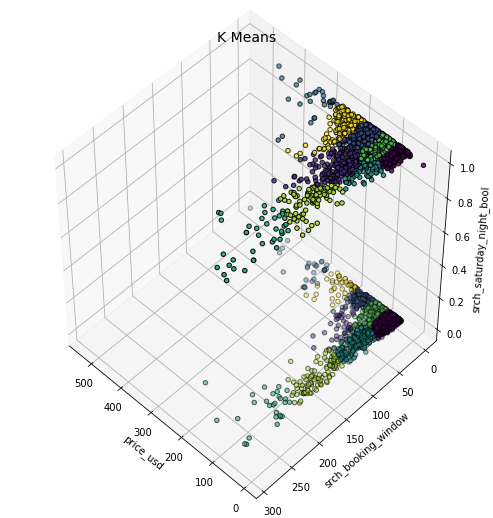

In [13]:
X = df[['price_usd', 'srch_booking_window', 'srch_saturday_night_bool']]
X = X.reset_index(drop=True)
km = KMeans(n_clusters=9) # changed from 10
km.fit(X)
km.predict(X)
labels = km.labels_

#Plotting
fig = plt.figure(1, figsize=(7,7))

ax = Axes3D(fig, rect=[0, 0, 0.95, 1], elev=48, azim=134)

ax.scatter(X.iloc[:,0], X.iloc[:,1], X.iloc[:,2],c=labels.astype(np.float), edgecolor="k") # Let's visualize the results by plotting the data colored by these labels.

ax.set_xlabel("price_usd")
ax.set_ylabel("srch_booking_window")
ax.set_zlabel("srch_saturday_night_bool")
plt.title("K Means", fontsize=14);

# Point/Cluster Distance
The underline assumption in the clustering approach is that if we cluster the data, normal data will belong to clusters while anomalies will not belong to any clusters or belong to small clusters.

In [14]:
import numpy as np
arr = data.to_numpy()
tab = np.array([])
for i in range(0,len(data)):
    Xa = arr[i]
    Xb = kmeans[9].cluster_centers_[kmeans[9].labels_[i]] #Xb = kmeans[9].cluster_centers_[kmeans[9].labels_[i]-1] #we can change the 9 too
    tab = np.append(tab, np.linalg.norm(Xa-Xb)) 

In [15]:
outliers_fraction = 0.01
distance = pd.DataFrame({'distance': tab})
number_of_outliers = int(outliers_fraction*len(distance))
threshold = distance.nlargest(number_of_outliers,'distance').min()
df['anomaly1'] = (distance >= threshold).astype(int)
print(df.anomaly1.value_counts(),"\n")
df.head()

0    3018
1      30
Name: anomaly1, dtype: int64 



,date_time,price_usd,srch_booking_window,srch_saturday_night_bool,anomaly1
0,2012-11-01 02:48:30,84.0,19,0,0
1,2012-11-01 03:06:43,78.0,16,1,0
2,2012-11-01 09:04:18,114.0,56,1,0
3,2012-11-01 09:11:03,76.0,56,1,0
4,2012-11-01 10:15:25,128.0,0,1,0


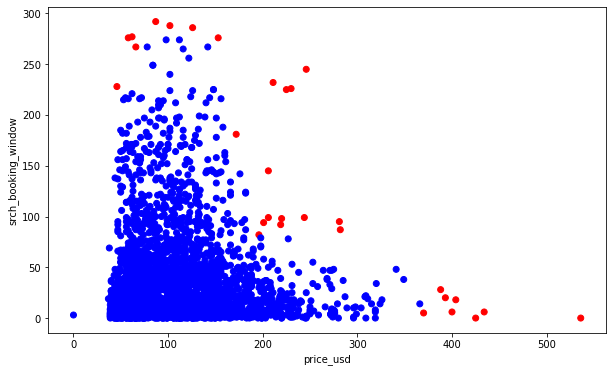

In [16]:
# visualisation of anomaly with cluster view
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(10,6))
colors = {0:'blue', 1:'red'}
ax.scatter(df['price_usd'], df['srch_booking_window'], c=df["anomaly1"].apply(lambda x: colors[x]))
plt.xlabel('price_usd')
plt.ylabel('srch_booking_window')
plt.show();

Scatter plot matrix does show or prove anything. Since the clusters vary from one k-means execution to another, the scatter plot varies, as well as the final graph with the anomalies shown on a time series, which in itself should trigger some doubts about the correctness. But if we chnage this Xb = model.cluster_centers_[model.labels_[i]-1] to Xb = model.cluster_centers_[model.labels_[i]] we always get the same result.

# Anomalies visualization using a time series

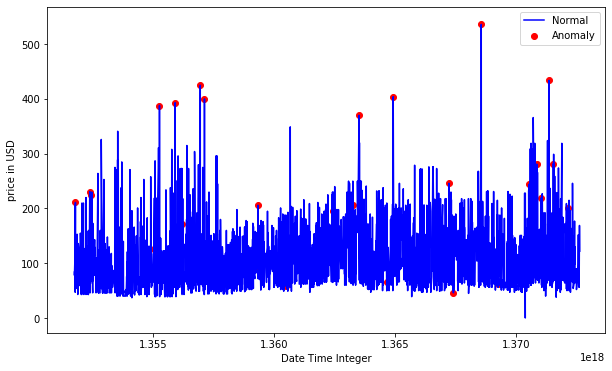

In [17]:
df['date_time']=pd.to_datetime(df['date_time'])
df = df.sort_values('date_time')
df['date_time_int'] = df.date_time.astype(np.int64)
fig, ax = plt.subplots(figsize=(10,6))

a = df.loc[df['anomaly1'] == 1, ['date_time_int', 'price_usd']] #anomaly

ax.plot(df['date_time_int'], df['price_usd'], color='blue', label='Normal')
ax.scatter(a['date_time_int'],a['price_usd'], color='red', label='Anomaly')
plt.xlabel('Date Time Integer')
plt.ylabel('price in USD')
plt.legend()
plt.show();

# Visualization of anomaly with re-partition

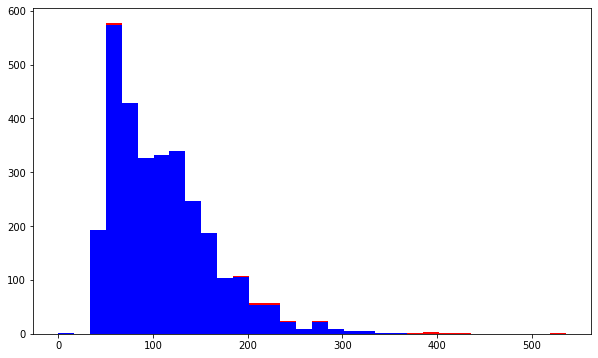

In [18]:
a = df.loc[df['anomaly1'] == 0, 'price_usd']
b = df.loc[df['anomaly1'] == 1, 'price_usd']

fig, axs = plt.subplots(figsize=(10,6))
axs.hist([a,b], bins=32, stacked=True, color=['blue', 'red'])
plt.show();